In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [20]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

V1         V2         V3         V4         V5         V6  \
time                                                                     
1      8.234563  34.357744  41.250916  41.194228  45.758237  40.424591   
2      8.074951  34.455387  39.598679  41.088167  44.970358  39.865248   
3      7.918439  34.622896  38.476926  41.116787  44.305423  39.256782   
4      7.629787  35.000000  37.800159  41.273497  43.786231  38.687338   
5      7.533917  35.494949  37.146960  41.534969  43.316534  38.307347   
...         ...        ...        ...        ...        ...        ...   
740   47.250000  11.000000   1.500000   4.250000   2.142857   3.000000   
741   48.333333  16.333333   2.750000   6.166667   3.500000   4.250000   
742   47.666667  18.833333   1.600000   4.857143   2.500000  34.114722   
743   41.875000  11.000000   3.600000   7.222222   3.200000   3.000000   
744   41.000000  11.600000   3.125000   8.200000   4.375000   4.500000   

             V7         V8         V9        V10  ...       V507       V508  \
time                                              ...                         
1     36.281097  37.844685  37.835138  44.057510  ...  49.152261  55.091967   
2     37.668302  37.439057  37.459381  43.493874  ...  48.586604  54.930351   
3     39.073064  37.170659  37.277562  43.126450  ...  48.238119  54.718230   
4     38.924916  37.083538  37.134224  42.761130  ...  47.738119  54.557624   
5     38.754882  37.050830  37.390285  42.526281  ...  47.731806  54.065200   
...         ...        ...        ...        ...  ...        ...        ...   
740    3.600000   1.000000   3.571429   1.857143  ...  35.125000  43.250000   
741    4.000000   2.500000   5.000000   3.000000  ...  40.000000  42.222222   
742    3.750000   2.400000   3.000000   2.400000  ...  38.000000  43.000000   
743    4.500000   2.750000   4.000000   3.625000  ...  31.500000  42.500000   
744    5.000000   3.285714   3.000000   4.000000  ...  23.000000  37.666667   

           V509       V510       V511       V512       V513       V514  \
time                                                                     
1     44.177585  42.569721  34.833622  38.084488  44.854870  46.933081   
2     44.329101  41.317196  34.651804  38.463276  45.044264  46.254293   
3     44.596777  40.512650  34.616450  38.384003  45.359416  45.830051   
4     45.104353  40.027802  34.730447  38.954315  45.789719  45.850253   
5     45.814310  39.700529  34.954690  39.820982  46.716991  45.994192   
...         ...        ...        ...        ...        ...        ...   
740   35.142857  27.250000  20.857143  34.142857  40.800000  32.375000   
741   32.571429  19.600000  20.800000  31.500000  38.166667  32.000000   
742   32.142857  14.666667  17.666667  19.000000  35.428571  30.333333   
743   21.400000   8.333333   8.833333  13.000000  27.000000  25.500000   
744   15.000000   3.800000   5.400000  11.000000  18.000000  13.800000   

           V515       V516  
time                        
1     45.600072  52.152083  
2     45.387951  51.495833  
3     45.212193  51.370833  
4     45.290981  51.386458  
5     45.903860  51.488542  
...         ...        ...  
740   33.500000  35.000000  
741   34.500000  37.500000  
742   34.222222  35.333333  
743   24.714286  24.200000  
744   13.500000  16.400000  

[744 rows x 516 columns]

In [21]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

latitude  longitude
device                     
V1         1.306    103.920
V2        23.741    120.755
V3        25.073    121.536
V4        25.119    121.505
V5        25.056    121.552
...          ...        ...
V512      23.366    120.366
V513      22.954    120.244
V514      22.945    120.230
V515      23.004    120.230
V516      23.222    120.400

[516 rows x 2 columns]

# 2. Model base + evaluation

In [22]:
df.iloc[:, 0].head(10)

time
1      8.234563
2      8.074951
3      7.918439
4      7.629787
5      7.533917
6      7.622310
7      8.015873
8      8.615079
9     12.857143
10     8.111111
Name: V1, dtype: float64

In [23]:
from sklearn.linear_model import RidgeCV
from abc import ABC, abstractmethod
from tqdm import tqdm

class Model(ABC):
    """
    Important:  make sure model.lookback and model.horizon are defined,
    these are used for the get_stats function.
    """
    @abstractmethod
    def fit(self, data):
        """
        Fits a h-step ahead model to the data.
        Forgets the previous fit if model was already fit.

        Parameters
        ----------
        data : pd.DataFrame
            The data to fit the model to.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        horizon : int
            The number of steps ahead to forecast.
        """
        ...

    @abstractmethod
    def predict(self, data):
        """
        Predicts X_{t+h} given X_t
        for each X_t (row) in the dataframe `data`.

        Parameters
        ----------
        data : pd.DataFrame
            The data to predict on.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        Returns
        -------
        pd.DataFrame
            The predicted values.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.
        """
        ...


class ARRidgeModel(Model):
    def __init__(self, lookback=5, horizon=1):
        self.lookback = lookback
        self.horizon = horizon

    def fit(self, data):
        models = [RidgeCV() for _ in range(len(data.columns))]
        for col_index, model in enumerate(models):
            col = data.iloc[:, col_index]
            # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
            # y[t] = X[t + horizon] (horizon steps ahead)

            y = col[self.lookback + self.horizon - 1:]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            y.index = X.index

            model.fit(X, y)


        self.models = models

    def predict(self, data):
        out = []
        for col_index, model in enumerate(self.models):
            col = data.iloc[:, col_index]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            out.append(model.predict(X))
        return pd.DataFrame(np.array(out).T, index=data.index[self.lookback - 1:-self.horizon], columns=data.columns)

model = ARRidgeModel()
model.fit(df)

In [24]:
model.predict(df)

V1         V2         V3         V4         V5         V6  \
time                                                                     
5      9.643548  35.858027  36.499209  41.161178  42.623762  37.797757   
6      9.732265  36.470871  36.142287  41.506138  42.321277  37.558999   
7     10.119888  37.216527  35.890976  41.485990  41.869820  37.564474   
8     10.642180  37.935998  35.953791  41.511261  41.899701  37.501823   
9     15.027971  41.419501  29.234489  50.041229  35.525886  35.846557   
...         ...        ...        ...        ...        ...        ...   
739   39.064957  12.635555   2.438970   6.013935   3.084051   5.817080   
740   46.399730  13.334899   3.244400   6.974930   4.541598   5.269639   
741   45.998018  19.709291   4.761223   8.876848   5.647300   6.691895   
742   45.347286  20.913625   3.152176   7.127002   4.159377  38.936538   
743   39.471493  11.841403   5.455429   9.888729   5.560053   0.160166   

             V7         V8         V9        V10  ...       V507       V508  \
time                                              ...                         
5     38.217698  36.626812  37.165038  42.085216  ...  49.336780  54.271976   
6     37.938035  36.988748  37.356669  41.911499  ...  48.863766  53.444952   
7     38.131096  37.347152  37.676540  41.945295  ...  48.369991  52.589440   
8     38.405107  37.566453  37.791112  42.156889  ...  48.046499  51.589104   
9     46.279224  34.426722  31.800556  44.637465  ...  53.238595  82.485596   
...         ...        ...        ...        ...  ...        ...        ...   
739    4.724197   2.931466   4.805642   4.785973  ...  32.115874  34.830372   
740    5.983692   2.935061   5.750915   4.190048  ...  38.928188  44.444137   
741    6.181899   4.587372   7.173867   5.574670  ...  43.345228  42.387840   
742    5.736021   4.239009   4.798756   4.619891  ...  42.002360  44.708563   
743    6.566321   4.610414   6.116089   6.187374  ...  36.162276  43.800479   

           V509       V510       V511       V512       V513       V514  \
time                                                                     
5     47.033823  39.582780  34.984210  40.967416  48.950171  46.365011   
6     47.760264  39.618078  34.870880  41.515591  49.817552  46.662881   
7     48.170407  39.706783  34.947782  41.986729  50.456679  46.880351   
8     49.047885  39.802183  35.072664  42.702263  51.335898  47.176368   
9     41.579507  36.620484  26.352241  39.826532  45.071917  35.489168   
...         ...        ...        ...        ...        ...        ...   
739   36.059827  33.724165  23.187787  32.855440  39.495430  32.954858   
740   37.682067  26.765903  22.055504  37.045707  44.255805  34.761630   
741   35.553225  20.300459  23.120347  32.542833  41.235813  34.419675   
742   35.870037  16.486007  19.366668  21.535861  39.466457  32.925621   
743   24.024812  10.419831  11.058469  17.268695  30.465552  28.164266   

           V515       V516  
time                        
5     47.170184  51.942071  
6     47.902543  52.412753  
7     48.390913  52.898986  
8     49.122200  53.325045  
9     40.847696  62.859409  
...         ...        ...  
739   37.363078  38.865478  
740   35.878036  36.802797  
741   37.538373  39.971684  
742   36.834785  36.614465  
743   26.841011  26.881052  

[739 rows x 516 columns]

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_stats(test_data, fitted_model):
    yhat = fitted_model.predict(test_data)
    y = test_data.iloc[fitted_model.lookback + fitted_model.horizon - 1:]
    y.index = yhat.index

    y_flat = y.values.flatten()
    yhat_flat = yhat.values.flatten()

    return pd.Series({
        "mse": mean_squared_error(y_flat, yhat_flat),
        "mae": mean_absolute_error(y_flat, yhat_flat),
        "r2": r2_score(y_flat, yhat_flat)
    })

get_stats(df, model) # in-sample stats

mse    50.006663
mae     4.460032
r2      0.855275
dtype: float64

# 3. Crossval

# 3.1. Crossval visualisation

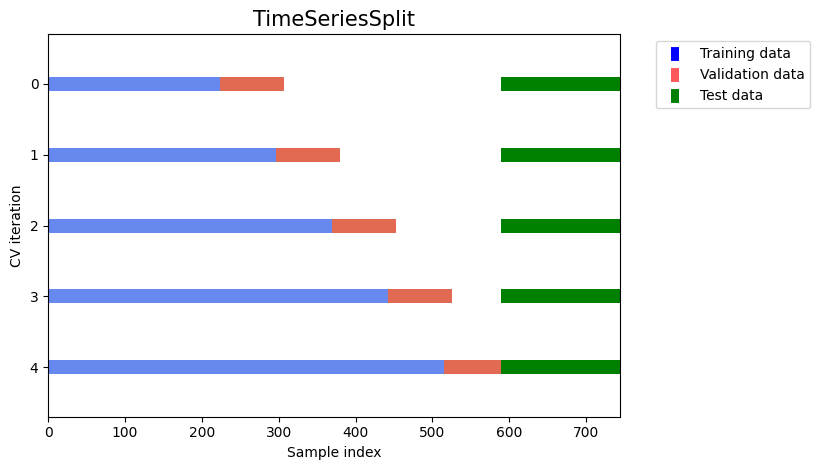

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, TimeSeriesSplit

cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, data_train, data, ax, n_splits, lw=10, lookback = 1, horizon = 1):
    """Create a sample plot for indices of a cross-validation object."""

    # Actual data column doesn't matter for CV visualization
    col = data_train.iloc[:, 0]
    # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
    # y[t] = X[t + horizon] (horizon steps ahead)

    y = col[lookback + horizon - 1:]
    X = pd.concat([
        col.iloc[i: -lookback + i].reset_index(drop=True)
        for i in range(lookback)
    ], axis=1, keys=[f"lag_{lookback - i - 1}" for i in range(lookback)])
    X.index = data_train.index[lookback - 1:-horizon]
    y.index = X.index

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

        # we also draw the test data from (len(X) to len(data))
        # green line
        ax.scatter(
            range(len(X), len(data)),
            [ii + 0.5] * (len(data) - len(X)),
            marker="_",
            lw=lw,
            #c=[1] * (len(data) - len(X)),
            #cmap=cmap_cv,
            #vmin=-0.2,
            #vmax=1.2,
            # we make it green
            c = "green"
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, len(data)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


TEST_FRAC = 0.2
n_train = int(len(df) * (1 - TEST_FRAC))
n_test = len(df) - n_train
df_train, df_test = df.iloc[:n_train], df.iloc[n_train:]

fig, ax = plt.subplots()
n_splits = 5
cv = TimeSeriesSplit(n_splits, test_size = (len(df) - 5) // 10)
plot_cv_indices(cv, df_train, df, ax, n_splits)
fig.tight_layout()

ax.scatter([], [], marker="_", lw=10, label="Training data", c="b")
ax.scatter([], [], marker="_", lw=10, label="Validation data", c="r", alpha=0.65)
ax.scatter([], [], marker="_", lw=10, label="Test data", c="g")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Our CV is set up such that we use at least half the data for training.

For the validation, we use 5 folds, and the test set is the last 20% of the data.

# 3.2. Cross-val grid search

In [27]:
def crossval(data, model, cv, horizon = 1, lookback = 5):
    stats = []
    for train_index, test_index in cv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model.fit(train)
        stats.append(get_stats(test, model))
    stats = pd.DataFrame(stats).T
    stats.columns.name = "fold"
    stats["mean"] = stats.mean(axis=1)
    return stats

print(crossval(df_train, ARRidgeModel(lookback = 1), cv))
print(crossval(df_train, ARRidgeModel(lookback = 5), cv))

fold          0          1          2          3          4       mean
mse   70.929587  48.011898  53.824459  39.774969  45.331210  51.574425
mae    4.466437   4.571377   4.814587   4.132677   4.780042   4.553024
r2     0.759325   0.843362   0.856079   0.797624   0.848117   0.820902
fold          0          1          2          3          4       mean
mse   62.261195  49.690415  52.221994  38.902493  44.068462  49.428912
mae    4.289390   4.631747   4.683435   4.105792   4.679999   4.478073
r2     0.775944   0.844441   0.860008   0.803559   0.851964   0.827183


In [28]:
from joblib import Parallel, delayed

grid = {
    "lookback": [1, 3, 5, 7, 9, 11, 13, 15]
}

def loss(lookback):
    model = ARRidgeModel(lookback = lookback)
    stats = crossval(df_train, model, cv, lookback = lookback)
    return stats.loc["mse", "mean"] # mean mse across folds

# grid search the loss function
results = pd.DataFrame({
    "lookback": grid["lookback"],
    #"mse": [loss(lookback) for lookback in grid["lookback"]]
    "mse": Parallel(n_jobs=-1)(delayed(loss)(lookback) for lookback in grid["lookback"])
})


Text(0.5, 1.0, 'Grid search')

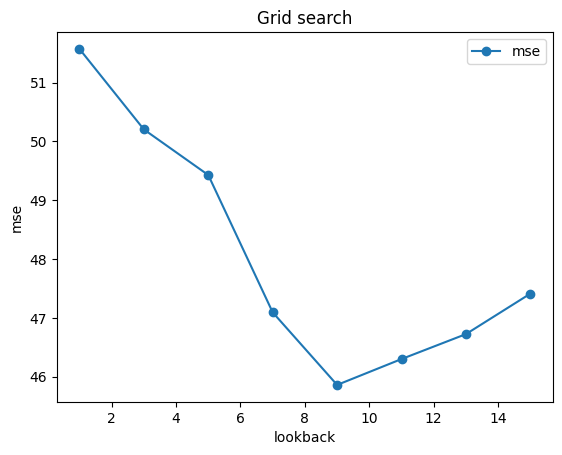

In [29]:
results.plot(x="lookback", y="mse", marker="o")
plt.xlabel("lookback")
plt.ylabel("mse")
plt.title("Grid search")

In [30]:
model = ARRidgeModel(lookback = 9)
model.fit(df_train)
get_stats(df_test, model)

mse    51.628500
mae     4.646927
r2      0.833997
dtype: float64

Naive autoregressive Ridge model per series with a lag length of 9 (found by crossval) leads to a test MSE of 51.629.

# 4. VAR model

In [31]:
from statsmodels.tsa import vector_ar
class VARModel(Model):
    def __init__(self, lookback=5, horizon=1):
        self.lookback = lookback
        self.horizon = horizon

    def fit(self, data):
        # each row is a time period, each column is a device
        self.model = vector_ar.VAR(data)
        

    def predict(self, data):
        out = []
        for col_index, model in enumerate(self.models):
            col = data.iloc[:, col_index]
            out.append(model.forecast(col.values[-self.lookback:], self.horizon))
        return pd.DataFrame(np.array(out).T, index=data.index[-self.horizon:], columns=data.columns)

In [32]:
from statsmodels.tsa.api import VAR
model = VAR(df_train.iloc[:, :200])
res = model.fit(1)
res.summary()


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Feb, 2024
Time:                     13:45:33
--------------------------------------------------------------------
No. of Equations:         200.000    BIC:                    741.773
Nobs:                     594.000    HQIC:                   560.508
Log likelihood:          -260500.    FPE:               4.18732e+195
AIC:                      444.883    Det(Omega_mle):    2.02208e+170
--------------------------------------------------------------------
Results for equation V1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -4.854834         3.553184           -1.366           0.172
L1.V1           0.719700         0.034444           20.895           0.000
L1.V2          -0.096708         0.082329           -1.175           0.240
L1.V3       

In [33]:
#res.plot()

In [34]:
import os
os.environ['R_HOME'] = '/usr/lib/R'

import rpy2
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
pandas2ri.activate()

sparsevar = importr('sparsevar')
rrpack = importr('rrpack')

In [44]:
r_df_train = pandas2ri.py2rpy(df_train)

In [75]:
#res = sparsevar.fitVAR(r_df_train, p = 1, penalty="ENET", method="cv", scale = True, parallel = True, ncores = 12, nlambda = 64)
X = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[:-1]))
# add intercept
X = r["cbind"](1, X)
Y = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[1:]))
Y = r["cbind"](1, Y)
#X = pd.DataFrame(np.random.randn(10, 100))
#Y = pd.DataFrame(np.random.randn(10, 100))
res = rrpack.rrr(Y, X, penaltySVD ="ann", ic_type = "GCV")

<Axes: >

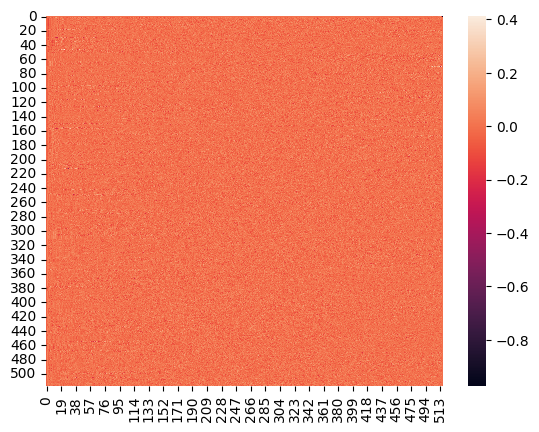

In [76]:
# get res$A
coef = res.rx2("A")
sns.heatmap(coef)

In [78]:
X.shape, Y.shape, coef.shape

((594, 517), (594, 517), (517, 517))

In [86]:
Y - X @ coef.T

array([[ 52.1465477 ,  -7.08947936,   3.74990319, ..., -36.08385267,
         15.38951103,  32.92862744],
       [ 51.51155421,  -7.09262198,   4.02103978, ..., -35.72952372,
         15.58290728,  32.83893558],
       [ 51.39276386,  -7.3981027 ,   5.00568971, ..., -35.27348607,
         15.59081447,  32.48823343],
       ...,
       [ 36.24469382,  21.44038228,  12.45926164, ..., -14.71101992,
         10.03559152,  20.55528561],
       [ 38.22368626,  12.05173809,  25.14712947, ..., -13.08184932,
          0.38213293,  20.26652924],
       [ 38.130374  ,   3.74381609,  40.77556225, ...,   2.31295097,
         12.15416326,   6.1731537 ]])

In [87]:
# get residuals
residuals = Y - X @ coef.T
# drop the intercept
residuals = residuals[:, 1:]
residuals = pd.DataFrame(np.array(residuals), index = df_train.index[1:], columns = df_train.columns)
residuals


V1         V2         V3         V4         V5         V6  \
time                                                                     
2     -7.089479   3.749903  31.515800  -5.621802  66.462360  33.767912   
3     -7.092622   4.021040  30.736775  -6.199666  65.186063  33.749669   
4     -7.398103   5.005690  30.452686  -6.239716  63.818796  33.627178   
5     -7.604049   6.365167  29.742203  -5.908246  62.890248  34.029892   
6     -7.513091   7.386897  28.578601  -5.648310  62.033966  34.466900   
...         ...        ...        ...        ...        ...        ...   
591   22.221781  -4.436785  -1.731858 -12.674939  22.208495   5.126960   
592   25.152699   5.831668   1.249533 -15.862363  25.028865   6.180874   
593   21.440382  12.459262  10.904559  -6.645107  31.846499  21.407414   
594   12.051738  25.147129   8.063915  -1.281491  34.581524  22.090051   
595    3.743816  40.775562   7.890773  -4.432688  40.321312  19.410852   

             V7         V8         V9        V10  ...       V507       V508  \
time                                              ...                         
2     55.971684  40.938887  61.744356  83.770475  ...   4.990354  94.179529   
3     56.946796  39.998658  61.623646  83.790313  ...   5.251301  92.657894   
4     56.332061  39.462686  61.464508  84.487361  ...   5.606983  91.393322   
5     55.926365  38.759946  61.808040  84.978495  ...   6.806585  90.218635   
6     56.180437  38.181816  62.260168  85.392957  ...   7.277361  88.279848   
...         ...        ...        ...        ...  ...        ...        ...   
591   23.857380  -1.445729  29.308521  37.062585  ...  11.910354  50.829368   
592   17.852008   2.814898  40.378448  39.681395  ...  19.482111  46.502191   
593   29.927930   6.359609  40.432943  39.512155  ...  16.750584  60.984966   
594   30.829246   8.579523  49.839686  31.149330  ...   5.266682  58.673300   
595   28.809358  18.902552  41.890645  28.136538  ...  22.280349  55.869028   

           V509       V510       V511       V512       V513       V514  \
time                                                                     
2     18.778158  55.790438  45.565045 -35.900135 -41.788149 -36.083853   
3     18.996231  54.614173  44.720569 -33.214923 -41.374004 -35.729524   
4     19.873062  53.727704  44.123003 -30.390609 -40.767865 -35.273486   
5     20.931987  53.647637  43.523474 -27.502356 -39.756889 -34.544242   
6     21.591288  53.647861  42.917455 -25.244129 -38.684007 -34.160284   
...         ...        ...        ...        ...        ...        ...   
591   16.068237  31.810523  11.324317 -14.228778 -38.546715 -26.437201   
592   12.841844  48.312601  17.431819  -5.071987 -13.041419 -10.167863   
593   10.145219  39.962872  15.505508   0.992988 -26.036196 -14.711020   
594   19.280103  36.050303  19.219437   4.271858 -10.603582 -13.081849   
595   25.931148  38.697254  16.957101 -11.949783   5.220515   2.312951   

           V515       V516  
time                        
2     15.389511  32.928627  
3     15.582907  32.838936  
4     15.590814  32.488233  
5     16.392072  31.985236  
6     16.929719  32.002596  
...         ...        ...  
591   -5.965826  11.451773  
592   10.060096  14.712138  
593   10.035592  20.555286  
594    0.382133  20.266529  
595   12.154163   6.173154  

[594 rows x 516 columns]